# Filtering inventory plots data using clustering procedure

Goal: from dataset obtained from satelite and radar imagery (spectral and terrain characteristics and their derrivatives) we want to obtain as mush of representative data as possible.
To do this on the data with different buffer-zone acquired by multiplying of radius of the invenotry plot, we perform clustering procedure.

1) K-means
* from the whole dataset we select only those records which correposponds to the largest cluster
* clustering procedure is performed on the non-correlated features
* number of clusters is selected autimatically according to the "elbow rule"
* clustering is performed by each plot

1.1. Attempt as it is <br>
1.2. Feature selection step using PCA. From first two components features with explained variation above third quartile were choosen.


In [14]:
!rm ../models/best_models/*joblib

In [7]:
import pandas as pd

In [24]:
df=pd.read_csv('../shape_data/metric_results_v2.csv')

In [25]:
list(df['fname'].unique())

['df1.csv',
 'df1_filtered_all.csv',
 'df1_filtered_by_bands.csv',
 'df1_filtered_by_bands_si.csv',
 'df1_filtered_by_bands_si_texture.csv',
 'df2.csv',
 'df2_filtered_all.csv',
 'df2_filtered_by_bands.csv',
 'df2_filtered_by_bands_si.csv',
 'df2_filtered_by_bands_si_texture.csv',
 'df3.csv',
 'df3_filtered_all.csv',
 'df3_filtered_by_bands.csv',
 'df3_filtered_by_bands_si.csv',
 'df3_filtered_by_bands_si_texture.csv',
 'df5.csv',
 'df5_filtered_all.csv',
 'df5_filtered_by_bands.csv',
 'df5_filtered_by_bands_si.csv',
 'df5_filtered_by_bands_si_texture.csv']

In [26]:
df

,Unnamed: 0,iteration,names,f1_scores,precision_list,recall,model,scale,is_filtered,fname,experiment_status
0,0,1,Birch,0.54,0.45,0.69,RandomForest,1,False,df1.csv,df1.csv
1,1,1,Aspen,0.58,0.63,0.54,RandomForest,1,False,df1.csv,df1.csv
2,2,1,Silver fir,1.00,1.00,1.00,RandomForest,1,False,df1.csv,df1.csv
3,3,1,Pine,0.79,0.82,0.75,RandomForest,1,False,df1.csv,df1.csv
4,4,2,Birch,0.57,0.74,0.47,RandomForest,1,False,df1.csv,df1.csv
...,...,...,...,...,...,...,...,...,...,...,...
4795,55,14,Pine,0.79,0.74,0.84,XGB,5,True,df5_filtered_by_bands_si_texture.csv,df5_filtered_by_bands_si_texture.csv
4796,56,15,Birch,0.36,0.55,0.27,XGB,5,True,df5_filtered_by_bands_si_texture.csv,df5_filtered_by_bands_si_texture.csv
4797,57,15,Aspen,0.50,0.45,0.57,XGB,5,True,df5_filtered_by_bands_si_texture.csv,df5_filtered_by_bands_si_texture.csv
4798,58,15,Silver fir,0.71,0.55,1.00,XGB,5,True,df5_filtered_by_bands_si_texture.csv,df5_filtered_by_bands_si_texture.csv


In [11]:
import seaborn as sns

<AxesSubplot:xlabel='model', ylabel='f1_scores'>

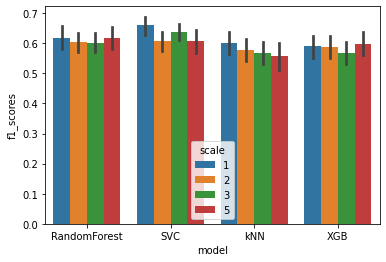

In [12]:
sns.barplot(x='model', y = 'f1_scores', hue = 'scale', data=df)

<AxesSubplot:xlabel='model', ylabel='f1_scores'>

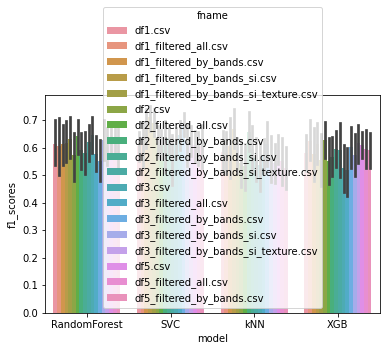

In [13]:
sns.barplot(x='model', y = 'f1_scores', hue = 'fname', data=df)

In [41]:
import traceback
print('we are here')
try:
    1/'23r'
except ZeroDivisionError:
    
    traceback.print_exc()
finally:
    
    print('and now')

we are here
and now


TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [3]:
!pip3 -q install yellowbrick

In [3]:
#libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer

from yellowbrick.cluster import KElbowVisualizer

import traceback

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#dataset

test = pd.read_csv('test_data-х3.csv', index_col=0)
test.head(2)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDVI,EVI,MSAVI,NDRE,aspect,slope,wetnessindex,sink,key,class
1,0.1126,0.08185,0.06775,0.04215,0.0656,0.16065,0.19045,0.17490,0.20245,0.06135,...,0.611610,0.260078,0.239022,0.454470,0.744224,0.034715,0.863035,0.75347,0,7
2,0.1126,0.08360,0.06815,0.04220,0.0656,0.16065,0.19045,0.17635,0.20245,0.06135,...,0.613818,0.262498,0.241437,0.457739,0.744224,0.034715,0.863035,0.75347,0,7


## K-means

In [6]:
#setting correlation threshold
correlation_threshold = 0.7

In [8]:
##selection of rows related to most abundant clusters

def get_selection(attmpt:pd.DataFrame)->pd.DataFrame:
    
    cluster_stat = attmpt.clusters.value_counts().to_dict()
    cluster_count = list(cluster_stat.values())
    cluster_non_equal = cluster_count[0]>cluster_count[1]
    if cluster_non_equal:
        target_cluster = list(cluster_stat.keys())[0]
        mask = attmpt.clusters == target_cluster
        data_grol = attmpt.loc[mask]
    else: 
        print('equal cluster')
        data_grol = pd.DataFrame()
    return data_grol

In [10]:
clustered_df = pd.DataFrame()
attmpt = pd.DataFrame()

for item in test.key.unique():
    try:
        attmpt = get_cluster_pixels(test, key=item)
        attmpt = get_selection(attmpt)
        clustered_df = pd.concat([clustered_df, attmpt])
        # Давай не будет делать перенос на новую строчку, end = '.'
        print(item, end= ' ') # mute at the final stage, needed for the check
    
    except KeyboardInterrupt():
        break


0 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 equal cluster
20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 equal cluster
37 38 39 40 41 42 equal cluster
43 44 45 46 47 equal cluster
48 49 50 51 52 53 54 55 56 57 58 59 equal cluster
60 61 equal cluster
62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127 equal cluster
128 129 130 132 133 134 135 136 137 138 139 141 142 143 144 equal cluster
145 146 147 148 149 150 151 152 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 equal cluster
182 183 184 185 186 187 188 equal cluster
189 190 191 192 193 194 195 196 197 198 199 200 201 equal cluster
202 equal cluster
203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 equal cluster
224 225 226 227 228 229 230 231 232 233 234 235 236 237

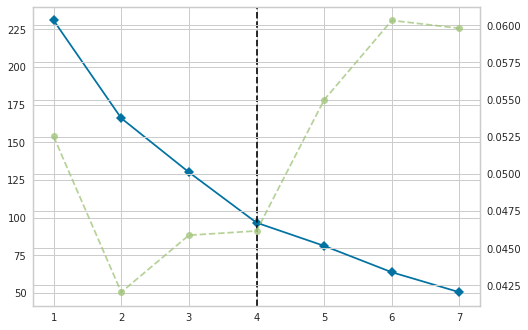

In [68]:
elbow_, attmpt = get_cluster_pixels(test, key=30)

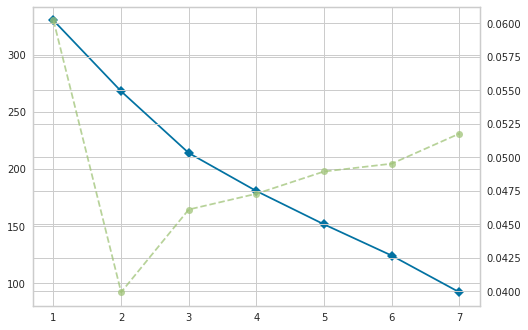

In [69]:
elbow_, attmpt = get_cluster_pixels(test, key=29)
# attmpt is 'no cluster'


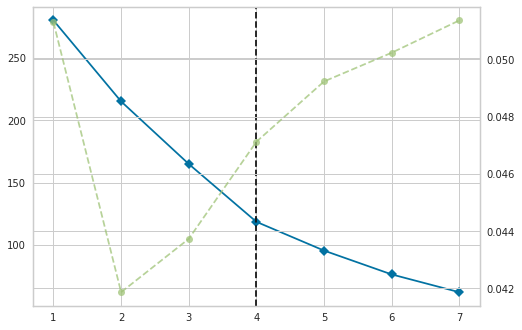

In [61]:
elbow_, attmpt = get_cluster_pixels(test, key=150)

In [43]:
attmpt

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,EVI,MSAVI,NDRE,aspect,slope,wetnessindex,sink,key,class,clusters
1,0.11415,0.08590,0.07280,0.04665,0.07175,0.20455,0.26220,0.25410,0.2906,0.08170,...,0.379650,0.361969,0.559613,0.744224,0.000000,0.000000,0.204221,30,1,2
2,0.11415,0.08605,0.07385,0.04730,0.07175,0.20455,0.26220,0.25205,0.2906,0.08170,...,0.374843,0.356981,0.556825,0.744224,0.000000,0.000000,0.204221,30,1,2
3,0.11415,0.08590,0.07660,0.04780,0.07125,0.20390,0.26305,0.25630,0.2834,0.08170,...,0.380191,0.362613,0.564952,0.744224,0.034715,0.839530,0.204221,30,1,2
4,0.11415,0.08425,0.07300,0.04720,0.07125,0.20390,0.26305,0.24130,0.2834,0.08170,...,0.358229,0.339646,0.544073,0.744224,0.034715,0.840498,0.224873,30,1,2
6,0.11500,0.08575,0.07640,0.04915,0.07150,0.21350,0.27610,0.26285,0.3000,0.08375,...,0.386911,0.369734,0.572304,0.744224,0.000000,0.000000,0.204221,30,1,1
7,0.11415,0.08395,0.07240,0.04670,0.07190,0.19995,0.25845,0.24350,0.2783,0.08170,...,0.362944,0.344511,0.544071,0.744224,0.000000,0.000000,0.204221,30,1,2
8,0.11415,0.08500,0.07540,0.04780,0.07190,0.19995,0.25845,0.23425,0.2783,0.08170,...,0.345541,0.326545,0.530296,0.744224,0.000000,0.000000,0.204221,30,1,2
9,0.11415,0.08590,0.07610,0.04855,0.07135,0.20250,0.26110,0.25150,0.2845,0.08170,...,0.370883,0.352937,0.557999,0.744224,0.034715,0.839530,0.204221,30,1,2
10,0.11415,0.08515,0.07185,0.04810,0.07135,0.20250,0.26110,0.24155,0.2845,0.08170,...,0.356395,0.337822,0.543944,0.744224,0.034715,0.840498,0.224873,30,1,2
11,0.11415,0.08315,0.07155,0.04590,0.07130,0.20085,0.25990,0.23610,0.2835,0.08170,...,0.353201,0.334300,0.536109,0.744224,0.000000,0.000000,0.224873,30,1,2


In [16]:
print('Rows kept from initial dataset is equal to', round(len(clustered_df)/len(test)*100), '%')

Rows kept from initial dataset is equal to 45 %


In [17]:
clustered_df['clusters'].unique()

array([1, 2, 0, 3], dtype=int32)

## PCA

THIS SCRIPT NEEDS TO BECOME PRETTIER

In [8]:
from sklearn.decomposition import PCA

In [9]:
def get_cluster_pixels_PCA(data:pd.DataFrame, key: int = 1)->pd.DataFrame: 
    try:
        #subsetting
        attmpt_pca_step = data[data.key == key]
        #abjusting columns
        cols_to_drop = ['key', 'class'] #'index',
        attempt_pca = attmpt_pca_step.drop(columns = cols_to_drop)
        
        #getting values and scalling them
        X = attempt_pca.values
        scaler_pca = StandardScaler()
        scaler_pca.fit(X)
        X_scaled = scaler_pca.transform(X)
        
        #performing of principal component analysis
        pca = PCA(n_components=20, random_state=2020)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        
        #selecting columns for clustering
        
        #first component
        stat_eigen = pd.DataFrame(pca.components_, 
                                  columns=attempt_pca.columns).T.loc[:, 0].abs().quantile(0.75)#.mean()#
        pca_results = pd.DataFrame(pca.components_,columns=attempt_pca.columns).T#.loc[mean_eqigen]
        mask_pca = pca_results.loc[:, 0].abs() > stat_eigen #selecting components with loads above third quartile 
        columns_for_clustering = pca_results.loc[mask_pca].index.tolist()
        
        #second component
        stat_eigen = pd.DataFrame(pca.components_,
                                  columns=attempt_pca.columns).T.loc[:, 1].abs().quantile(0.75)#.mean()#
        pca_results = pd.DataFrame(pca.components_,columns=attempt_pca.columns).T#.loc[mean_eqigen]
        mask_pca = pca_results.loc[:, 1].abs() > stat_eigen #selecting components with loads above third quartile
        second_component = pca_results.loc[mask_pca].index.tolist()
        
        #final list of columns for clustering
        columns_for_clustering = columns_for_clustering+second_component
        
        # filtering subset by columns from previous step
        data_for_clustering = attempt_pca.loc[:, columns_for_clustering]
        
        #BACK TO K-MEANS
         
        #preprocessing of the data
        #from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(data_for_clustering)#'index',
        scaled_data = scaler.transform(data_for_clustering)#'index',

        #from yellowbrick.cluster import KElbowVisualizer
        model = KMeans()
        # k is range of number of clusters.
        visualizer = KElbowVisualizer(model, k=(1,8), timings= True)
        visualizer.fit(scaled_data)        # Fit data to visualizer
        plt.close()

        kmeans_model = KMeans(n_clusters = visualizer.elbow_value_, random_state=100) # elbow_value_ == number of clusters
        kmeans_model.fit(scaled_data)

        attmpt_pca_step["clusters"] = kmeans_model.labels_
        #attmpt.clusters.value_counts().reset_index()#.duplicated(subset=['clusters'])#.iloc[0,0]
        return attmpt_pca_step
    except:
        pass

In [10]:
##selection of rows related to most abundant clusters

def get_selection_PCA(attmpt_pca_step:pd.DataFrame)->pd.DataFrame:
    
    cluster_stat = attmpt_pca_step.clusters.value_counts().to_dict()
    cluster_count = list(cluster_stat.values())
    cluster_non_equal = cluster_count[0]>cluster_count[1]
    if cluster_non_equal:
        target_cluster = list(cluster_stat.keys())[0]
        mask = attmpt_pca_step.clusters == target_cluster
        data_grol = attmpt_pca_step.loc[mask]
    else: 
        print('equal cluster')
        data_grol = pd.DataFrame()
    return data_grol

In [11]:
clustered_df_PCA = pd.DataFrame()
attmpt = pd.DataFrame()

for item in test.key.unique():
    try:
        attmpt = get_cluster_pixels_PCA(test, key=item)
        attmpt = get_selection_PCA(attmpt)
        clustered_df_PCA = pd.concat([clustered_df_PCA, attmpt])
        print(item) # mute at the final stage, needed for the check
    except:
        pass

0
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
equal cluster
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
equal cluster
41
42
43
44
45
46
47
48
49
equal cluster
50
equal cluster
51
52
53
54
55
56
57
58
59
60
61
62
equal cluster
63
64
65
66
67
68
69
70
71
72
equal cluster
73
74
75
76
77
78
79
80
81
82
83
equal cluster
84
equal cluster
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
equal cluster
108
109
110
111
112
113
equal cluster
114
equal cluster
115
116
117
118
119
120
122
123
124
125
126
equal cluster
127
128
129
equal cluster
130
132
133
equal cluster
134
135
136
137
equal cluster
138
139
141
142
143
144
145
146
147
148
149
150
151
152
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
equal cluster
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
equal cluster
193
194
195
196
197
198
199
200
equal cluster
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
2

In [16]:
print('Rows kept from initial dataset is equal to', round(len(clustered_df_PCA)/len(test)*100), '%')

Rows kept from initial dataset is equal to 45 %


# 🤸

In [ ]:

df = pd.read_csv()

no_0_df = df[df<0]

result = df.head(5)
